In [1]:
import os
from functools import partial
import re
from itertools import chain

import pandas as pd
import albumentations as A
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError

from src.constants import DATA_PATH
from src.dataset import MultimodalDataset, collate_fn, get_transforms, get_ingredients_idx
from src.utils import MultimodalModel, seed_everything, train, validate, plot_images_flatten

/home/russele7/practicum/dle/sprint_4/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

# Этап 1. EDA

## 1.1 Загрузка данных

In [3]:
dish_path = f'{DATA_PATH}dish.csv'
ingredients_path = f'{DATA_PATH}ingredients.csv'

In [4]:
df_dish = pd.read_csv(dish_path)
df_ing = pd.read_csv(ingredients_path)

In [5]:
df_ing

,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad
3,4,bacon
4,5,potatoes
...,...,...
550,551,pizza sauce
551,552,pomegranate
552,553,nut cheese
553,554,soy sausage


In [6]:
df_dish

,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train
...,...,...,...,...,...
3257,dish_1563295334,228.540009,96.0,ingr_0000000004;ingr_0000000008,train
3258,dish_1566329234,262.625214,457.0,ingr_0000000161;ingr_0000000189;ingr_000000000...,train
3259,dish_1562691737,485.676880,700.0,ingr_0000000543;ingr_0000000027;ingr_000000012...,train
3260,dish_1558458496,53.130001,77.0,ingr_0000000440,train


## 1.2 Визуализация данных

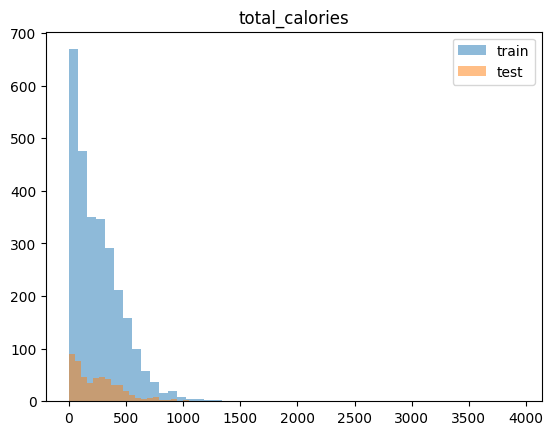

In [7]:
plt.hist(df_dish[df_dish['split'] == 'train']['total_calories'], bins=50, alpha=0.5, label='train')
plt.hist(df_dish[df_dish['split'] == 'test']['total_calories'], bins=20, alpha=0.5, label='test')
plt.title('total_calories')
plt.legend()

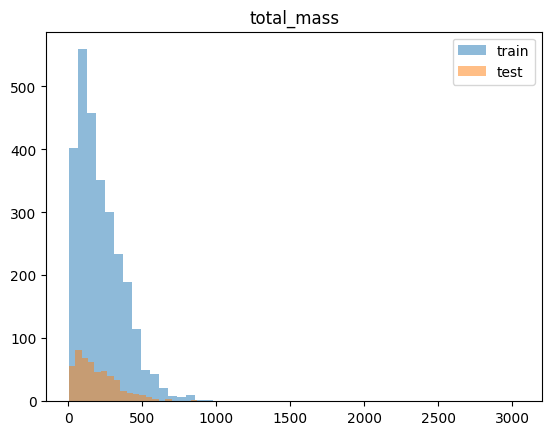

In [8]:
plt.hist(df_dish[df_dish['split'] == 'train']['total_mass'], bins=50, alpha=0.5, label='train')
plt.hist(df_dish[df_dish['split'] == 'test']['total_mass'], bins=20, alpha=0.5, label='test')
plt.title('total_mass')
plt.legend()

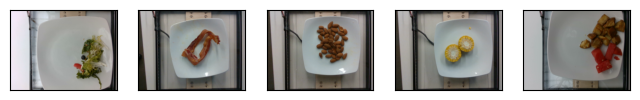

In [9]:
plot_images_flatten(df_dish['dish_id'])

## 1.3 Обработка текстового описания - переход к токенам. (при обучении модели данные операции будут проходить "под капотом")

In [10]:
dict_ingredients = {k:v for k, v in zip(df_ing['id'], df_ing['ingr'])}
dict_ingredients

{1: 'cottage cheese',
 2: 'strawberries',
 3: 'garden salad',
 4: 'bacon',
 5: 'potatoes',
 6: 'caesar salad',
 7: 'cauliflower',
 8: 'scrambled eggs',
 9: 'wild rice',
 10: 'steak',
 11: 'cheese pizza',
 12: 'olives',
 13: 'berries',
 14: 'asparagus',
 15: 'hash browns',
 16: 'brussels sprouts',
 17: 'pasta salad',
 18: 'turkey',
 19: 'bread',
 20: 'duck',
 21: 'squash',
 22: 'guacamole',
 23: 'brown rice',
 24: 'artic char',
 25: 'beef',
 26: 'white rice',
 27: 'broccoli',
 28: 'chicken',
 29: 'mixed greens',
 30: 'lettuce',
 31: 'cucumbers',
 32: 'tomatoes',
 33: 'bell peppers',
 34: 'celery',
 35: 'blue cheese',
 36: 'spinach (raw)',
 37: 'cantaloupe',
 38: 'pineapple',
 39: 'sausage',
 40: 'raspberries',
 41: 'blackberries',
 42: 'avocado',
 43: 'green beans',
 44: 'bean sprouts',
 45: 'carrot',
 46: 'mushroom',
 47: 'corn',
 48: 'ham',
 49: 'fish',
 50: 'tofu',
 51: 'shrimp',
 52: 'cheese',
 53: 'nuts',
 54: 'apple',
 55: 'banana',
 56: 'kiwi',
 57: 'lemon',
 58: 'orange',
 59: '

In [11]:
df_dish['ingredients_idx'] = df_dish['ingredients'].apply(lambda x: get_ingredients_idx(x))

In [12]:
df_dish.head()

,dish_id,total_calories,total_mass,ingredients,split,ingredients_idx
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test,"[508, 122, 26, 524, 94, 23, 189, 54, 29, 328, ..."
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train,"[312, 26, 29, 122, 508, 513, 520, 525, 161, 94..."
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test,"[448, 520, 462, 514, 152, 312, 291, 45, 122, 6..."
3,dish_1560455030,20.590000,103.0,ingr_0000000471;ingr_0000000031;ingr_0000000347,train,"[471, 31, 347]"
4,dish_1558372433,74.360001,143.0,ingr_0000000453,train,[453]


## 1.4 Сформируйте видение
- Как решать задачу: Мультимодальная нейросеть. Картинка + текст + масса блюда
- какие подходы к обогащению/аугментации данных примените и почему: 
    - Изображения - аффинные повороты, яркость-контрастность-насыщенность-оттенки, размытие, шум. После этих обработок не нарушается концепция изображения, и компоненты все еще можно разглядеть
    - Тексты: аугментация за счет перестановки токенов. Т.к. порядок перечисления компонентов не важен
### 
- на какие метрики будете ориентироваться при обучении: MAE, MSE, MAPE

# Этап 2. Реализуйте пайплайн обучения

## 2.1 Загрузчики данных и датасеты

In [13]:
# Реализовано в src

## 2.2 Опциональный код предобработки/аугментации данных

In [14]:
# Реализовано в src

## 2.3 Код обучения и валидации для импортирования в виде одной функции

In [15]:
# Реализовано в src

## 2.4 Конфиг-файл для запуска модели и сохранения результатов обучения

In [ ]:
class Config:
    SEED = 42

    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"

    BATCH_SIZE = 16 #256
    TEXT_LR = 3e-5
    IMAGE_LR = 1e-4
    REGRESSOR_LR = 1e-3
    EPOCHS = 20 #30
    DROPOUT = 0.2
    HIDDEN_DIM = 256

    SAVE_PATH = "models/best_model.pth"

In [17]:
config = Config()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [18]:
device

'cuda'

## 2.5 Код для получения воспроизводимых результатов (seed) с выводом метрик

In [19]:
# Реализовано в src

# Этап 3. Обучение модели

## 3.1 Вызов метода обучения с передачей конфига

In [20]:
train(config, device)

Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.11.output.dense.weight
Разморожен слой: encoder.layer.11.output.dense.bias
Разморожен слой: encoder.layer.11.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.output.LayerNorm.bias
Разморожен слой: pooler.dense.weight
Раз

  0%|          | 0/204 [00:00<?, ?it/s]/home/russele7/practicum/dle/sprint_4/practicum_dle_sprint_4/src/utils.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_features = torch.tensor(mass_input).unsqueeze(1)
100%|██████████| 204/204 [01:25<00:00,  2.39it/s]


Epoch 0/1 | avg_Loss: 232.5948 | Train MAE: 232.6133| Val MAE: 211.6416
New best model, epoch: 0
epoch 1


100%|██████████| 204/204 [01:27<00:00,  2.33it/s]


Epoch 1/1 | avg_Loss: 188.2695 | Train MAE: 188.2369| Val MAE: 165.5005


# Этап 4. Валидация

## 4.1 Расчет целевой метрики на тестовом датасете

In [21]:
model = MultimodalModel(config)
model.load_state_dict(torch.load(config.SAVE_PATH))
model = model.to(device)

tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL_NAME)

val_transforms = get_transforms(config, mode="test")
val_dataset = MultimodalDataset(config, val_transforms, mode="test")
val_loader = DataLoader(val_dataset,
                        batch_size=config.BATCH_SIZE,
                        shuffle=False,
                        collate_fn=partial(collate_fn,
                        tokenizer=tokenizer,
                        mode="test"))

In [22]:
mae_valid = validate(model, val_loader, device, MeanAbsoluteError().to(device))
mape_valid = validate(model, val_loader, device, MeanAbsolutePercentageError().to(device))
mse_valid = validate(model, val_loader, device, MeanSquaredError().to(device))

  0%|          | 0/204 [00:00<?, ?it/s]/home/russele7/practicum/dle/sprint_4/practicum_dle_sprint_4/src/utils.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mass_features = torch.tensor(mass_input).unsqueeze(1)
100%|██████████| 204/204 [01:27<00:00,  2.32it/s]


In [23]:
print(f'MAE on TEST = {mae_valid}\n'
      f'MSE on TEST = {mse_valid}\n'
      f'MAPE on TEST = {mape_valid}\n')

MAE on TEST = 211.6415557861328
MSE on TEST = 89567.4765625
MAPE on TEST = 26588.080078125



## 4.2 Выведите топ-5 блюд, по которым оценка модели наименее точна. Опишите возможные причины низкого качества на этих примерах.

In [24]:
y_true, y_predict = [], []
dish_list = []
with torch.no_grad():
    for batch in tqdm(val_loader):

        inputs = {
            'text_input': {'input_ids': batch['input_ids'].to(device),
                            'attention_mask': batch['attention_mask'].to(device)},
            'image_input': batch['image'].to(device),
            'mass_input': batch['total_mass'].to(device)
        }

        targets = batch['target'].to(device)

        dish_ids = batch['dish_id']

        preds = model(**inputs).squeeze()

        y_true.append(targets.to('cpu').numpy())
        y_predict.append(preds.to('cpu').numpy())
        dish_list.append(dish_ids)

y_true = np.concatenate(y_true)
y_predict = np.concatenate(y_predict)
dish_list = list(chain(*dish_list))

100%|██████████| 204/204 [01:53<00:00,  1.80it/s]


In [25]:
df = pd.DataFrame({'dish_id': dish_list,'y_true': y_true, 'y_predict': y_predict})
df['abs_delta'] = abs(df['y_true'] - df['y_predict'])
df = df.sort_values('abs_delta', ascending=False)

In [26]:
df

,dish_id,y_true,y_predict,abs_delta
1518,dish_1560974769,3943,50.972042,3892.027958
124,dish_1565033265,1324,51.180149,1272.819851
2753,dish_1562603895,1268,51.187767,1216.812233
1125,dish_1564170010,1264,51.161846,1212.838154
1951,dish_1563476577,1238,51.137589,1186.862411
...,...,...,...,...
129,dish_1558723414,51,50.936573,0.063427
2913,dish_1560444701,51,51.035816,0.035816
1252,dish_1561665626,51,50.972633,0.027367
289,dish_1562774099,51,50.978340,0.021660


ТОП 5 блюд с наихудшим предсказанием


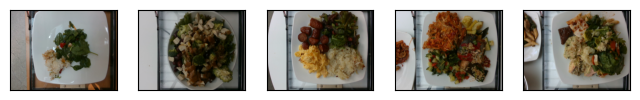

In [27]:
print(f'ТОП 5 блюд с наихудшим предсказанием')
plot_images_flatten(df['dish_id'][:5], sample_flg=False)

ТОП 5 блюд с наилучшим предсказанием


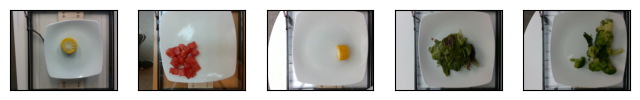

In [28]:
print(f'ТОП 5 блюд с наилучшим предсказанием')
plot_images_flatten(df['dish_id'][-5:], sample_flg=False)

### Причины низких предсказаний - сложный, многочисленный состав. Чем проще рецепт - тем выше качество